# DRLND Project 1 - Navigation (Banana environment)

This notebook presents a solution to the [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) Project 1 - Navigation of the [Unity3D](https://unity3d.com/machine-learning/) [Udacity Banana environment (Mac version)](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip) (a version of the [Unity Banana Collector](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md) environment [shown here](https://youtu.be/heVMs3t9qSk) modified for a single agent) where the goal is to navigate using four actions:

- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

to collect as many YELLOW bananas as possible while avoiding BLUE bananas (see image of environment below). 

<img src="Unity3D Banana environment.png" width=400px>

The solution is patterned on [udacity/deep-reinforcement-learning](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution) and thus has files:
- `DRLND Project 1 - Navigation (Banana environment).ipynb` (this notebook)
- `dqn_agent.py` - specifies methods of the **Agent** class including choice of action and learning method  
- `model.py` - specifies **QNetwork** architecture

As per the project [rubric](https://review.udacity.com/#!/rubrics/1889/view), this repository also contains files:
- `README.md` - with setup instructions
- `REPORT.md` - describes the learning algorithm, hyperparameters and model architecture

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

If you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

The **UnityEnvironment** class, including the **no_graphics** flag, is defined [here](https://github.com/udacity/deep-reinforcement-learning/blob/master/python/unityagents/environment.py).

In [2]:
env = UnityEnvironment(file_name="/Users/johngraves/Documents/20180711/deep-reinforcement-learning/p1_navigation/Banana.app",
                      no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity environments offer a variety of methods:

In [3]:
_ = [print(item) for item in dir(env) if not item.startswith('_')]

academy_name
brain_names
brains
close
communicator
curriculum
executable_launcher
external_brain_names
get_communicator
global_done
logfile_path
number_brains
number_external_brains
port
proc1
reset
send_academy_parameters
step
wrap_unity_input


Environments contain **brains** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:')
_ = [print(index,value) for index, value in enumerate(state)]

state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like:
0 1.0
1 0.0
2 0.0
3 0.0
4 0.8440813422203064
5 0.0
6 0.0
7 1.0
8 0.0
9 0.07484719902276993
10 0.0
11 1.0
12 0.0
13 0.0
14 0.2575500011444092
15 1.0
16 0.0
17 0.0
18 0.0
19 0.7417734265327454
20 0.0
21 1.0
22 0.0
23 0.0
24 0.25854846835136414
25 0.0
26 0.0
27 1.0
28 0.0
29 0.0935567170381546
30 0.0
31 1.0
32 0.0
33 0.0
34 0.3196934461593628
35 0.0
36 0.0
States have length: 37


### 3. Take Random Actions in the Environment
This code cell shows how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will wait while the agent performs, selecting an action (uniformly) at random with each time step. A **Score** is returned at the end, representing the number of YELLOW bananas collected minus the number of BLUE bananas collected.

In [6]:
%%time
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0
CPU times: user 326 ms, sys: 70 ms, total: 396 ms
Wall time: 30.3 s


### 4. Training

Model summary using [pytorch-summary](https://github.com/sksq96/pytorch-summary)

In [7]:
from dqn_agent import Agent
import torch
from torchsummary import summary
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

agent = Agent(state_size=len(env_info.vector_observations[0]),
              action_size=brain.vector_action_space_size,
              seed=0)
_ = [print(item) for item in dir(agent) if not item.startswith('_')]

act
action_size
learn
memory
optimizer
qnetwork_local
qnetwork_target
seed
soft_update
state_size
step
t_step


In [8]:
summary(agent.qnetwork_local, input_size=(1, len(env_info.vector_observations[0])))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,432
           Dropout-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,160
           Dropout-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 4]             260
Total params: 6,852
Trainable params: 6,852
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [9]:
summary(agent.qnetwork_target, input_size=(1, len(env_info.vector_observations[0])))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,432
           Dropout-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,160
           Dropout-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 4]             260
Total params: 6,852
Trainable params: 6,852
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


Episode 100	Average Score: 0.43
Episode 200	Average Score: 2.14
Episode 300	Average Score: 5.19
Episode 400	Average Score: 9.950
Episode 498	Average Score: 13.05
Environment solved in 498 episodes!	Average Score: 13.05
Episode 500	Average Score: 13.16

Environment score after 500 episodes!	Average Score: 13.16

Environment max score in 500 episode!	Best Score: 13.16


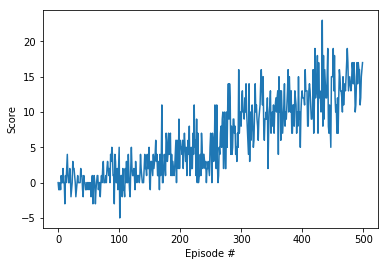

In [10]:
def dqn(n_episodes=500, 
        max_t=1000, 
        eps_start=1.0, 
        eps_end=0.01, 
        eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    solved = False
    max_score = -9999
    best_episode = -1
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if np.mean(scores_window) > max_score:
            max_score = np.mean(scores_window)
            best_episode = i_episode
            
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if not solved and np.mean(scores_window)>=13.0:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')          
        elif i_episode == n_episodes:
            print('\nEnvironment score after {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                           np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_final.pth')
    
    if not solved:
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_final_not_solved.pth')
    print('\nEnvironment max score in {:d} episode!\tBest Score: {:.2f}'.format(best_episode, max_score))
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Test

In [13]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_final.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0.01)                # select an action using final policy
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Final Score: {}".format(score))

Final Score: 18.0


Sequence of **Final Scores** before score above: 5.0, 10.0

So 13 is clearly ONLY an average score. Much lower scores are possible.